# Анализ датасета Дом.рф (ООП)

Анализ датасета по строящимся домам с сайта Дом.рф был проделан мной в парадигме ООП с использованием двух классов DomDataLoader и DomDataVisualizer.

In [1]:
import requests
import pandas as pd
from tqdm.auto import tqdm
from sqlalchemy import create_engine

class DomDataLoader:
    
    def __init__ (self):
        d=[]
        for i in tqdm(range(100)):
            offset_ = 1+i*100
            limit_ = 100
            url = f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/kn/object?offset={offset_}&limit={limit_}&sortField=devId.devShortCleanNm&sortType=asc&objStatus=0'
            res = requests.get(url)
            objects_data = res.json()
            objects_data.get('data').get('list')[0]
            objects_list = objects_data.get('data').get('list')
            objids = [x.get('objId') for x in objects_list]
            objids[:10]
            for obj in objids:
                url=f'https://xn--80az8a.xn--d1aqf.xn--p1ai/%D1%81%D0%B5%D1%80%D0%B2%D0%B8%D1%81%D1%8B/api/object/{obj}'
                res=requests.get(url)
                d.append(res.json())
        self.df=pd.json_normalize(d)
    
    def toPikle(self):
        self.df.to_pickle('./output.pkl')
        
    def toJSON(self):
        return (self.df.to_json(orient = 'index'))
        
    def toSQL(self):
        engine = create_engine('sqlite://', echo=False)
        self.df.to_sql('index', con=engine)
    
    def toExcel(self):
        self.df.to_excel('output.xlsx')

In [2]:
Loader=DomDataLoader()
df=Loader.df

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets.widgets import interact
sns.set_theme(style = 'ticks', palette = 'GnBu_d')

class DomDataVisualizer:
    
    def __init__ (self, df):
        self.df= df
    
    def RegionCountPlot(self):
        sns.countplot(x = 'data.region',
              data = df,
              order = df['data.region'].value_counts().iloc[:5].index).set(xlabel='Код региона', ylabel='Число строящихся объектов')
    
    
    def RegionPricesBoxPlot(self):
        sns.catplot(x = 'data.region',
                    y = 'data.objPriceAvg',
                    kind = 'box',
                    data = df[['data.region','data.objPriceAvg']].dropna(subset=['data.objPriceAvg']),
                    order = df['data.region'].value_counts().iloc[:5].index).set(xlabel='Код региона', ylabel='Цена квадратного метра жилья')
    
    
    def GetAddressMaxPricePerM2 (self):
        print(self.df.iloc[self.df['data.objPriceAvg'].idxmax()]['data.address'])
    
    
    def InteractiveMetroBoxPlot(self):
        
        def TechMetroBoxPlot(Region):
            sns.catplot(x='data.metro.isWalk',
                        y= 'data.objPriceAvg',
                       kind = 'box',
                        data = df[df['data.region'] == Region][['data.objPriceAvg', 'data.metro.isWalk']].dropna(subset=['data.objPriceAvg']).fillna(bool(''))).set(xlabel='Метро в пешей доступности?', ylabel='Цена квадратного метра жилья')
        group = [77, 66, 78, 16, 50]
        interact(TechMetroBoxPlot, Region = group)

Проанализируем регионы по количеству строящихся домов при помощи метода RegionCountPlot(). В топе оказались Москва (77 регион), Краснодар (23 регион), Московская область (50 регион), Санкт-Петербург (78 регион), Пензенская область (54 регион). Удивил Краснодар - бурно развивающийся город-миллионник на юге России и Пенза.

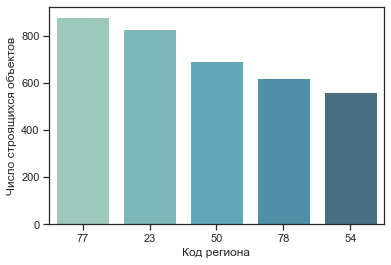

In [9]:
Visualizer=DomDataVisualizer(df)
Visualizer.RegionCountPlot()

Посмотрим теперь на распределение цен квадратного метра жилья в новостройках этого региона. Для этого используем метод RegionPricesBoxPlot() класса DomDataVisualizer. Предварительно метод отбрасывает строки с пропусками, так как при большом количестве данных додумывать свои цены не вижу смысла. Ожидаемо, с отрывом лидируют столицы - Москва, Петербург, уже за ними идут остальные города.

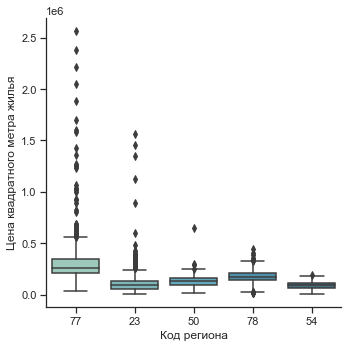

In [10]:
Visualizer.RegionPricesBoxPlot()

Особенно удивляют выбросы за 75ым перцентилем ящика с усами. Москва шокирует нас рекордом - домом с ценой более 2.5 млн рублей за 1 квадратный метр. При поимощи метода GetAddressMaxPricePerM2() найдем адресс самого дорогой новостройки столицы, да и всей России.

In [11]:
Visualizer.GetAddressMaxPricePerM2()

г Москва, район Мещанский, переулок Малый Сухаревский, строение 2, вл. 4


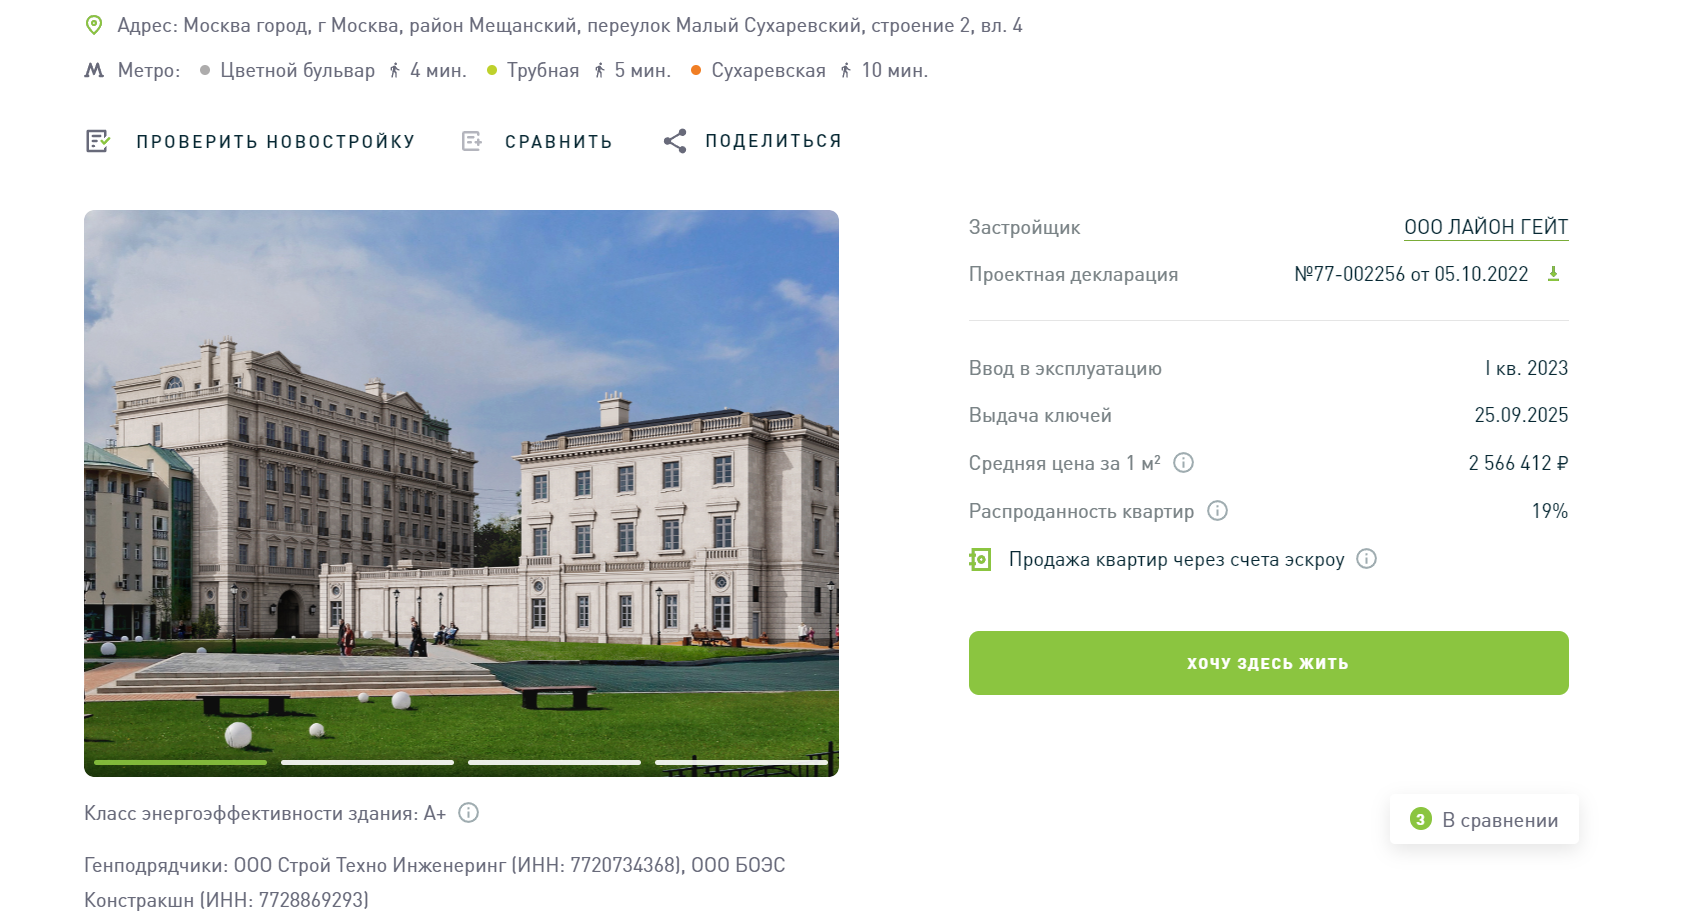

Действительно, датасет нас не обманывает, цена квадратного метра в этом особняке на Цветном бульваре в Москве составляет 2 566 412 ₽.

При помощи метода InteractiveMetroBoxPlot() хочу проверить гипотезу: в любом регионе квартиры с маркером "Метро в шаговой доступности" дороже квартир без этого маркера. Предварительно метод обрабатывает пропуски - заполняет их значением False, так как я предполагаю, что застройщики тех домов, которые реально находятся у метро, точно это отметили для повышения спроса.

In [12]:
Visualizer.InteractiveMetroBoxPlot()

interactive(children=(Dropdown(description='Region', options=(77, 66, 78, 16, 50), value=77), Output()), _dom_…

Интерактивная диаграмма ящик с усами показывает нам, что в Москве (77 регион), Екатеринбурге (66 регион), Санкт-Петербурге (78 регион) эта гипотеза выполняется. В Казани (16 регион) недостаточно данных в датасете для того, чтобы утверждать это наверняка. В Московской области (50 регион), близость к метро дает значимый эффект разве что на минимальную цену квадратного метра в новостройке. Возможно это связано с тем, что в области в принципе не так много станций метро и часть застройщиков приукрашивают ситуацию (пишут, что дом рядом с метро, ставя соответствубщий маркер, а на деле дом вовсе не близко). 